In [1]:
import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import os

import torch

from tqdm.notebook import tqdm

from scipy.spatial import distance_matrix

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')


In [4]:
methods = ['d2', 'd2-ms', 'd2-fast-ap-revised-ms', 'd2-fast-ap-revised']
names = ['D2-Net', 'D2-Net MS', 'D2-Net Fast AP 1', 'D2-Net Fast AP 2']
colors = ['purple', 'cyan', 'black', 'red']
linestyles = ['-', '-', '--', '--']

In [5]:
dataset_path = 'hpatches-sequences-release'
extension = 'ppm'
top_k = 2000
def read_function(seq_name, method, im_idx):
    aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
    assert('scores' in aux)
    ids = np.argsort(aux['scores'])[-top_k :]
    return aux['keypoints'][ids, :], aux['descriptors'][ids, :]

In [6]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [7]:
errors = {}
for method in methods:
    seq_names = sorted(os.listdir(dataset_path))
    rng = np.arange(1, 16)
    i_TP_FN = {thr: 0 for thr in rng}
    v_TP_FN = {thr: 0 for thr in rng}
    i_TP_FP = {thr: 0 for thr in rng}
    v_TP_FP = {thr: 0 for thr in rng}
    i_TP = {thr: 0 for thr in rng}
    v_TP = {thr: 0 for thr in rng}
    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints, descriptors = read_function(seq_name, method, 1)
        for img_idx in range(2,7):
            keypoints_1, descriptors_1 = read_function(seq_name, method, img_idx)
            matches = mnn_matcher(
                            torch.tensor(descriptors).to(device=device), 
                            torch.tensor(descriptors_1).to(device=device)
            )
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(img_idx)))
            pos_a = keypoints[matches[:, 0], : 2] 
            selected_keypoints = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            selected_keypoints_1 = keypoints_1[matches[:, 1]]
            projection_h = (homography @ selected_keypoints.T).T
            projection = projection_h[:,:2]/projection_h[:,2:]
            pos_b = selected_keypoints_1[:,:2]
            dist = np.sqrt(np.sum((pos_b - projection) ** 2, axis=1))
            
            all_pos_a = keypoints[:, : 2]
            all_pos_a_h = np.concatenate([all_pos_a, np.ones([all_pos_a.shape[0], 1])], axis=1)
            all_proj_h = (homography @ all_pos_a_h.T).T
            all_proj = all_proj_h[:,:2]/all_proj_h[:,2:]
            all_pos_b = keypoints_1[:,:2]
            dist_mat = distance_matrix(all_proj, all_pos_b)
            min_array = np.min(dist_mat, axis=1)

            for thr in rng:
                if seq_name[0] == 'i':
                    i_TP_FN[thr] += np.sum(min_array <= thr)
                    i_TP_FP[thr] += dist.size
                    i_TP[thr] += np.sum(dist <= thr)
                else:
                    v_TP_FN[thr] += np.sum(min_array <= thr)
                    v_TP_FP[thr] += dist.size
                    v_TP[thr] += np.sum(dist <= thr)
    errors[method] = [i_TP, v_TP, i_TP_FN, v_TP_FN, i_TP_FP, v_TP_FP]
np.save('results.npy', errors)

In [8]:
errors

{'d2': [{1: 40902,
   2: 75617,
   3: 99980,
   4: 118798,
   5: 132128,
   6: 141070,
   7: 147372,
   8: 152062,
   9: 155347,
   10: 157637,
   11: 159172,
   12: 160405,
   13: 161385,
   14: 162135,
   15: 162687},
  {1: 18253,
   2: 48362,
   3: 74618,
   4: 95101,
   5: 110052,
   6: 120893,
   7: 128825,
   8: 134627,
   9: 138668,
   10: 141542,
   11: 143669,
   12: 145245,
   13: 146346,
   14: 147215,
   15: 147933},
  {1: 45234,
   2: 89747,
   3: 127506,
   4: 163721,
   5: 197155,
   6: 226780,
   7: 254147,
   8: 278823,
   9: 300418,
   10: 317564,
   11: 331422,
   12: 342722,
   13: 352060,
   14: 359390,
   15: 365264},
  {1: 23556,
   2: 68619,
   3: 117394,
   4: 166186,
   5: 212912,
   6: 256468,
   7: 296263,
   8: 331486,
   9: 361456,
   10: 386413,
   11: 407513,
   12: 424724,
   13: 438822,
   14: 450439,
   15: 460021},
  {1: 187480,
   2: 187480,
   3: 187480,
   4: 187480,
   5: 187480,
   6: 187480,
   7: 187480,
   8: 187480,
   9: 187480,
   10: 1874

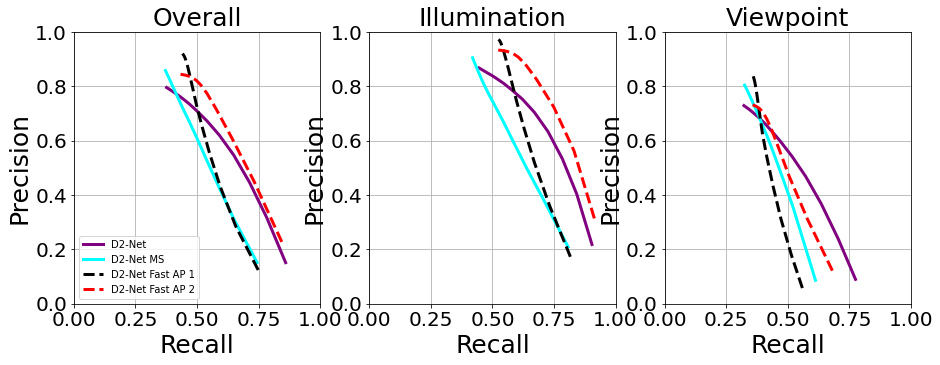

In [9]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    t_precision = [(errors[method][0][i]+errors[method][1][i])/(errors[method][4][i]+errors[method][5][i]) for i in range(1,16)]
    t_recall    = [(errors[method][0][i]+errors[method][1][i])/(errors[method][2][i]+errors[method][3][i]) for i in range(1,16)]
    plt.plot(t_recall, t_precision, color=color, ls=ls, linewidth=3, label=name)
plt.title('Overall')
plt.xlim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_precision = [errors[method][0][i]/errors[method][4][i] for i in range(1,16)]
    i_recall    = [errors[method][0][i]/errors[method][2][i] for i in range(1,16)]
    plt.plot(i_recall, i_precision, color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
plt.xlim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    v_precision = [errors[method][1][i]/errors[method][5][i] for i in range(1,16)]
    v_recall    = [errors[method][1][i]/errors[method][3][i] for i in range(1,16)]
    plt.plot(v_recall, v_precision, color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
plt.xlim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

